In [1]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import io
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import tqdm, trange
from flygym.util.config import all_leg_dofs, leg_dofs_3_per_leg
from flygym.state import stretched_pose

import cv2


from flygym.util.cpg_controller import (advancement_transfer, phase_oscillator, sine_output, initialize_solver,
                         phase_biases_tripod_measured, phase_biases_tripod_idealized,
                         phase_biases_ltetrapod_idealized, phase_biases_metachronal_idealized,
                         plot_phase_amp_output)

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [3]:
# Initialize the simulation
run_time = 1
enable_adhesion = True

sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.05,
    render_fps=30,
    render_camera="Animat/camera_right_top_zoomout",
    render_window_size=(700, 560),
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    adhesion_gain=20,
    draw_contacts=False,
)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos = [0.0, 0.0, 0.5]
)

num_steps_base = int(run_time / nmf.timestep)

In [4]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

leg_swing_starts = {k:v/nmf.timestep for k,v in data["swing_stance_time"]["swing"].items()}
leg_stance_starts = {k:v/nmf.timestep for k,v in data["swing_stance_time"]["stance"].items()}

In [6]:
legs = ["LF", "LM", "LH", "RF", "RM", "RH"]
n_oscillators = len(legs)

t = np.arange(0, run_time, nmf.timestep)

n_joints = len(nmf.actuated_joints)
leg_ids = np.arange(len(legs)).astype(int)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

# Coxa joint of each leg (recover the advancement of the leg)
joints_to_leg = np.array([i for ts in nmf.last_tarsalseg_names for i, joint in enumerate(nmf.actuated_joints) if f"{ts[:2]}Coxa_roll" in joint])
stance_starts_in_order = np.array([leg_stance_starts[ts[:2]] for ts in nmf.last_tarsalseg_names])
swing_starts_in_order = np.array([leg_swing_starts[ts[:2]] for ts in nmf.last_tarsalseg_names])

In [7]:
match_leg_to_joints

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5])

In [8]:
# lets say we want 10 oscillations in the time period
n_steps = 12
frequencies = np.ones(n_oscillators) * n_steps / run_time

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(n_oscillators) * 1.0
rates = np.ones(n_oscillators) * 20.0

phase_biases = phase_biases_tripod_idealized * 2 * np.pi

coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 

# Simulation

In [9]:
n_stabilisation_steps = 2000
num_steps = n_stabilisation_steps + num_steps_base

# Initilize the simulation
np.random.seed(0)
start_ampl = np.ones(6)*0.2
obs, info = nmf.reset()
solver = initialize_solver(phase_oscillator, "dopri5", nmf.curr_time,
                            n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                start_ampl, rates,
                                int_params={"atol": 1e-6, "rtol": 1e-6, "max_step":100000})


# Initalize storage
obs_list = []
phases = np.zeros((num_steps, n_oscillators))
amplitudes = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))
input_joint_angles = np.zeros(len(nmf.actuated_joints))

indices = np.zeros_like(nmf.actuated_joints, dtype=np.int64)

for i in trange(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i == n_stabilisation_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                target_amplitudes, rates)
    if i > n_stabilisation_steps:
        indices = advancement_transfer(phase, interp_step_duration, match_leg_to_joints)
        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = data_block[joint_ids, 0] + \
                  (data_block[joint_ids, indices]-data_block[joint_ids, 0])*amp[match_leg_to_joints]
    else:
        input_joint_angles = data_block[joint_ids, 0]

    joint_angles[i, :] = input_joint_angles
    if enable_adhesion:
        #adhesion_signal = nmf.get_adhesion_vector()
        adhesion_signal = np.logical_or(indices[joints_to_leg] < swing_starts_in_order,
                                         indices[joints_to_leg] > stance_starts_in_order)
        
    else:
        adhesion_signal = np.zeros(6)

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list.append(obs)
    nmf.render()

100%|██████████| 12000/12000 [00:41<00:00, 290.32it/s]


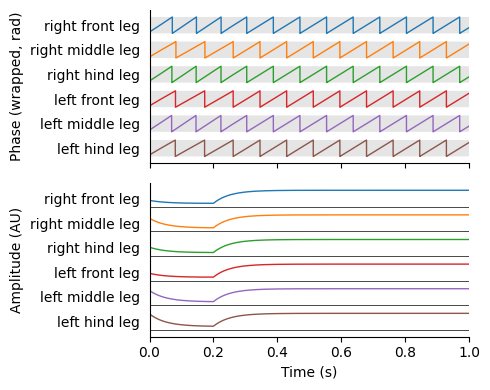

In [10]:
timestep = nmf.timestep
labels = legs
rule_labels = ["Retraction", "Stumbling"]
leg_basey_lookup = {
    "right front leg": 0,
    "right middle leg": -1,
    "right hind leg": -2,
    "left front leg": -3,
    "left middle leg": -4,
    "left hind leg": -5,
}
leg_name_lookup = {
    "RF": "right front leg",
    "LF": "left front leg",
    "RM": "right middle leg",
    "LM": "left middle leg",
    "RH": "right hind leg",
    "LH": "left hind leg",
}
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}

time = timestep * np.arange(len(phases))

def plot_frame(current_time=None, video_layout=False):
    if video_layout:
        fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 2), tight_layout=True)
    else:
        fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4), tight_layout=True)

    # phase plot
    ax = axs.flatten()[0]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        phase_ts = np.mod(phases[:, i], np.pi * 2)
        ax.plot(
            time,
            phase_ts + leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.fill_between(
            time,
            leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            leg_basey_lookup[leg_name] * np.pi * 3 + np.pi,
            facecolor="gray",
            edgecolor="none",
            alpha=0.2,
            zorder=-1,
            linewidth=1,
        )
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * np.pi * 3)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Phase (wrapped, rad)")

    # amplitude plot
    ax = axs.flatten()[1]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        amp_ts = amplitudes[:, i]
        ax.plot(
            time,
            amp_ts + leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        if current_time is not None:
            ax.axvline(current_time, color="red", linewidth=2, zorder=100)
        ax.axhline(
            leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    if video_layout:
        ax.set_yticks([])
        ax.set_yticklabels([])
    else:
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 1.5)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Amplitude (AU)")
    ax.set_xlabel("Time (s)")

    sns.despine()
    return fig

plt.style.use("default")
fig = plot_frame()
fig.savefig("outputs/cpg.pdf", transparent=True)

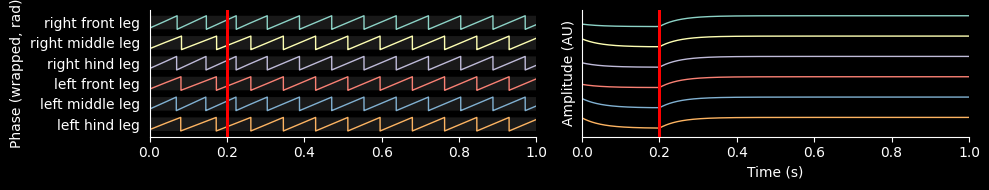

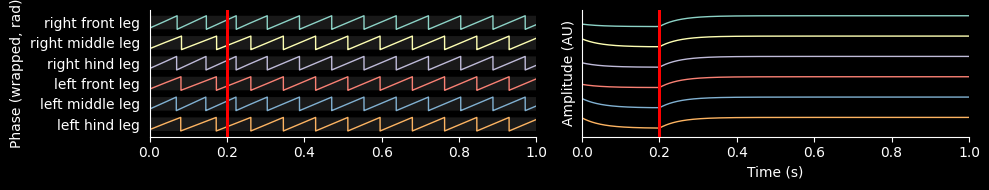

In [11]:
plt.style.use("dark_background")
plot_frame(current_time=0.2, video_layout=True)

In [12]:
def matplotlib_figure_to_array(fig):
    """Adapted from https://stackoverflow.com/a/67823421/13560623"""
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    return data.reshape((int(h), int(w), -1))

In [13]:
def merge_frame_and_time_series(i, frame):
    current_time = i * nmf._eff_render_interval
    time_series_fig = plot_frame(current_time, video_layout=True)
    time_series_img = matplotlib_figure_to_array(time_series_fig)
    plt.close(fig=time_series_fig)
    assert frame.shape[0] >= time_series_img.shape[0]
    # height = time_series_img.shape[0]
    # frame_width = int(height * frame.shape[1] / frame.shape[0])
    # frame = cv2.resize(frame, (frame_width, height))
    # merged_frame = np.concatenate([frame, time_series_img[:, :, :3]], axis=1)
    width = frame.shape[1]
    ts_height = int(width * time_series_img.shape[0] / time_series_img.shape[1])
    time_series_img = cv2.resize(time_series_img, (width, ts_height))
    merged_frame = np.concatenate([frame[:, :, :3], time_series_img[:, :, :3]], axis=0)
    return merged_frame

In [14]:
#n_frames_to_drop = int(n_stabilisation_steps * nmf.timestep / nmf._eff_render_interval)
frames_to_render = nmf._frames#[n_frames_to_drop:]
video_shape = merge_frame_and_time_series(0, frames_to_render[0]).shape

out = cv2.VideoWriter(
    "outputs/cpg.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    sim_params.render_fps,
    (video_shape[1], video_shape[0]),
)

for i, frame in tqdm(enumerate(frames_to_render), total=len(frames_to_render)):
    merged_frame = merge_frame_and_time_series(i, frame)
    out.write(merged_frame[:, :, ::-1])  # RGB to BGR
out.release()

  0%|          | 0/720 [00:00<?, ?it/s]

100%|██████████| 720/720 [01:33<00:00,  7.73it/s]


: 